<a href="https://colab.research.google.com/github/puneethegde72/Weighing-supermassive-black-holes-using-Gaussian-Processes/blob/main/Weighing_Supermasive_backhole_project_final_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
#Importing all The required Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from matplotlib.ticker import *
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ExpSineSquared
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_squared_error, r2_score
from scipy.fft import fft, fftfreq
from scipy.signal import butter, lfilter
from sklearn.impute import KNNImputer

In [41]:

# Defining Colours
col1 = "#3F5D7D"  # nice deep blue
col2 = '#ff7f0e'  # orange color
col3 = '#1f77b4'  # another shade of blue

In [42]:
def load_data(data_file):
  data = np.genfromtxt(data_file)
  juldate = data[:, 1]
  tsec = juldate - juldate.min()
  t = tsec / 1000.0
  y = data[:, 2]
  y_error = data[:, 3]
  return t, y, y_error,juldate.min()

In [43]:
def compute_model(num_training_data,parameters, Likelihood ):
  # Compute and print the BIC
  n = num_training_data  # Number of data points
  print("training datapoint",n)
  k = len(parameters)  # Number of parameters used in the model
  print("K",k)

  a=(-2)* Likelihood
  print('a=', a)
  aa=((np.log(n))*k)
  print('aa=', aa)
  #BIC = ((-2)* log_likelihood) + (np.log(n)*k)
  BIC=a+aa
  print("Bayesian Information Criterion (BIC):", BIC)


  # Calculate AICc
  AIC = 2 * k - 2 * Likelihood
  print('AIC=',AIC)
  edf=(n - k - 1) #effective degrees of freedom
  b= (2 * k * (k + 1))
  AICc = (AIC + b)/ edf
  print('(2 * k * (k + 1))=', b)
  print('(n - k - 1)=', edf)
  print("Corrected Akaike Information Criterion (AICc):", AICc)

  no_parameter= k

  return BIC, AICc, no_parameter

In [44]:
def Gaussian_process(t, y, y_error, box, k, juldate_zero=None, col1=col1, col2=col2, length_scale=0.14):

  X = t.reshape(-1, 1)  # reshape the time array for input to the Gaussian Process Regressor
  y = y.reshape(-1, 1)  # reshape the observed data array
  num_training_data = X.shape[0]  # or y.shape[0]
  print("Number of training data points:", num_training_data)

  kernel = k
  n_opt= 30
  #RBF(length_scale=length_scale) + WhiteKernel(noise_level=0.01)  # create a kernel for the Gaussian Process Regressor
  gpr = GaussianProcessRegressor(kernel=kernel, alpha=y_error, normalize_y=False)  # create a Gaussian Process Regressor with the specified kernel
  gpr.fit(X, y)  # fit the Gaussian Process Regressor to the data

  #finding the final value here.
  print("final values of the kernals are:",gpr.kernel_)
  # Get the log-likelihood of the fitted model
  log_likelihood = gpr.log_marginal_likelihood()

  print('log_likelihood=', log_likelihood)

  return juldate_zero, gpr, log_likelihood, gpr.kernel_, gpr.kernel_.theta,num_training_data,X


In [45]:
def plot_results(t, y, y_error, y_pred, sigma, box, x, col1=col1, col2=col2):
  print("starting")
  box.plot(t, y, color=col1, linewidth=1.5, label='Observations')  # plot the observed data
  plt.errorbar(
      t,
      y.flatten(),
      yerr=y_error.flatten(),
      linestyle="None",
      color="tab:red",
      marker=".",
      markersize=5,
      label="Error",
      )  # plot error bars representing noise in the data
  box.plot(x , y_pred, color=col2, linewidth=1.5, label='Gaussian Process')  # plot the Gaussian Process
  #print(y_pred)
  box.fill_between(x.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color=col2, alpha=0.2, label=r"95% confidence interval")  # fill the area between predictions with uncertainty
  plt.title(str(gpr.kernel_))
  plt.legend(loc='upper right', fontsize="6")  # add a legend to the plot
  name= "Boxplot1_"+str(final_kernal_value)+".png"
  plt.savefig(name)

  plt.show()  # display the plot

In [46]:
def compute_fft(t, y):
    dt = t[1] - t[0]  # Time step
    n = len(y)  # Number of data points
    freqs = np.fft.fftfreq(n, dt)  # Frequencies corresponding to FFT components
    fft_vals = fft(y)  # Compute FFT

    # Keep only positive frequencies (excluding zero) and corresponding FFT values
    positive_nonzero_freq_indices = np.where((freqs > 0) & (fft_vals != 0))
    freqs_positive_nonzero = freqs[positive_nonzero_freq_indices]
    fft_vals_positive_nonzero = fft_vals[positive_nonzero_freq_indices]

    amplitude = np.abs(fft_vals_positive_nonzero) / n
    phase = np.angle(fft_vals_positive_nonzero)

    return freqs_positive_nonzero, amplitude, phase

In [47]:
  # Data files
data_files = ['fvar_soft_dt1000_ob1.dat', 'fvar_soft_dt1000_ob2.dat', 'fvar_soft_dt1000_ob3.dat',
              'fvar_soft_dt1000_ob4.dat', 'fvar_soft_dt1000_ob5.dat', 'fvar_soft_dt1000_ob6.dat']


In [48]:
# List of kernels
kernels = [
    1.0**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01),
    1.0**2 * RBF(length_scale=0.14) + 1.0**2 *RBF(length_scale=0.01) + WhiteKernel(noise_level=0.01),
    1.0**2 * RBF(length_scale=0.14) + 1.0 *Matern(length_scale=0.1) + WhiteKernel(noise_level=0.01),
    1.0**2 * RBF(length_scale=0.24) + 1.0**2 *RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01),
    1.0**2 * RBF(length_scale=0.1) + ExpSineSquared(length_scale=0.1, periodicity=0.1) +WhiteKernel(noise_level=0.01),
    1.0**2 * RBF(length_scale=0.4) + ExpSineSquared(length_scale=0.0001, periodicity=0.1)+ WhiteKernel(noise_level=0.01),
    1.0**2 * RBF(length_scale=0.4) + 1.0**2 *RBF(length_scale=0.2) + 1.0**2 *RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
]


In [49]:
kernels

[1**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01),
 1**2 * RBF(length_scale=0.14) + 1**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=0.01),
 1**2 * RBF(length_scale=0.14) + 1**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.01),
 1**2 * RBF(length_scale=0.24) + 1**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01),
 1**2 * RBF(length_scale=0.1) + ExpSineSquared(length_scale=0.1, periodicity=0.1) + WhiteKernel(noise_level=0.01),
 1**2 * RBF(length_scale=0.4) + ExpSineSquared(length_scale=0.0001, periodicity=0.1) + WhiteKernel(noise_level=0.01),
 1**2 * RBF(length_scale=0.4) + 1**2 * RBF(length_scale=0.2) + 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)]

In [50]:
Result_Table_box1 = pd.DataFrame(columns=['Kernel', 'k','log likelihood','BIC', 'AICc'])

kernals: 1**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)
Number of training data points: 123
final values of the kernals are: 4.63**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.299)
log_likelihood= -363.99678927591077
training datapoint 123
K 3
a= 727.9935785518215
aa= 14.436553066117252
Bayesian Information Criterion (BIC): 742.4301316179387
AIC= 733.9935785518215
(2 * k * (k + 1))= 24
(n - k - 1)= 119
Corrected Akaike Information Criterion (AICc): 6.369693937410265
starting


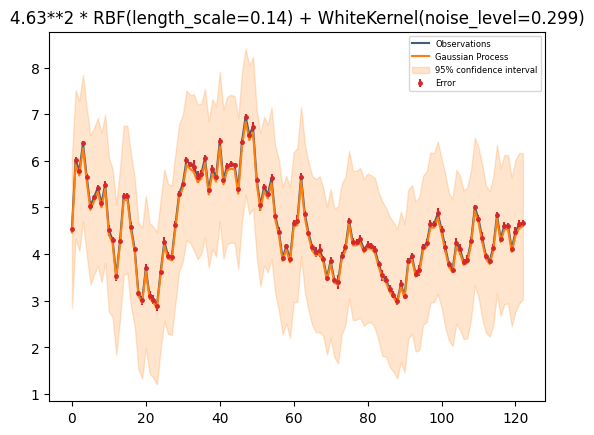

<ipython-input-68-322490e2b774>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


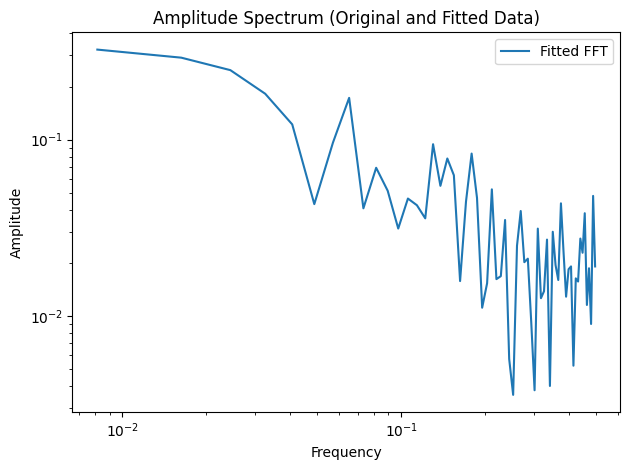

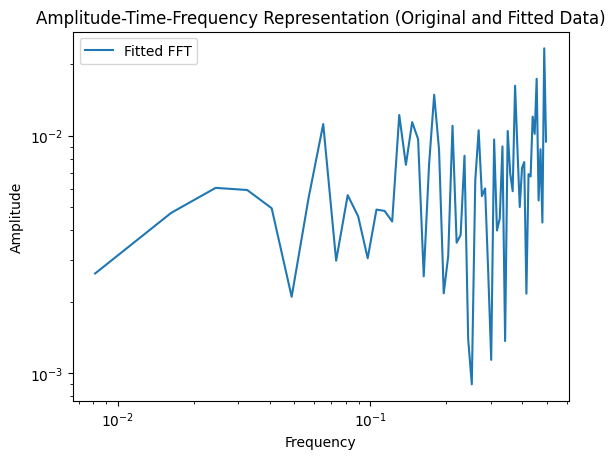

kernals: 1**2 * RBF(length_scale=0.14) + 1**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=0.01)
Number of training data points: 123
final values of the kernals are: 3.29**2 * RBF(length_scale=0.14) + 3.29**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=0.018)
log_likelihood= -363.99678927640156
training datapoint 123
K 5
a= 727.9935785528031
aa= 24.060921776862084
Bayesian Information Criterion (BIC): 752.0545003296652
AIC= 737.9935785528031
(2 * k * (k + 1))= 60
(n - k - 1)= 117
Corrected Akaike Information Criterion (AICc): 6.8204579363487445
starting


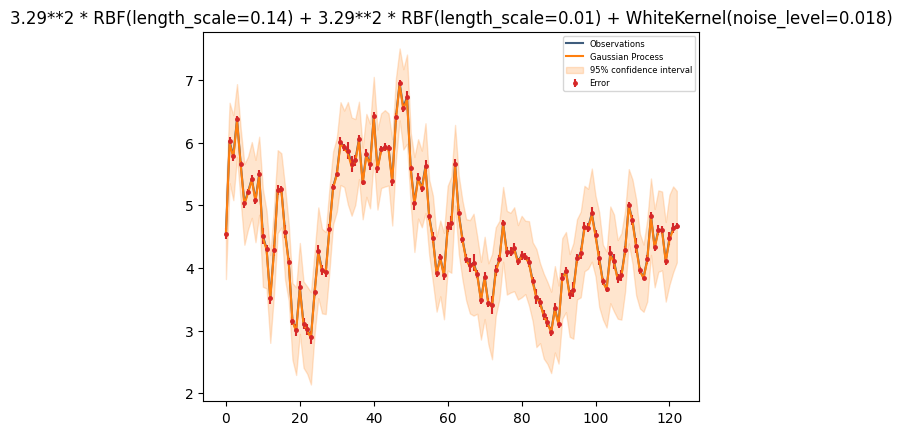

<ipython-input-68-322490e2b774>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


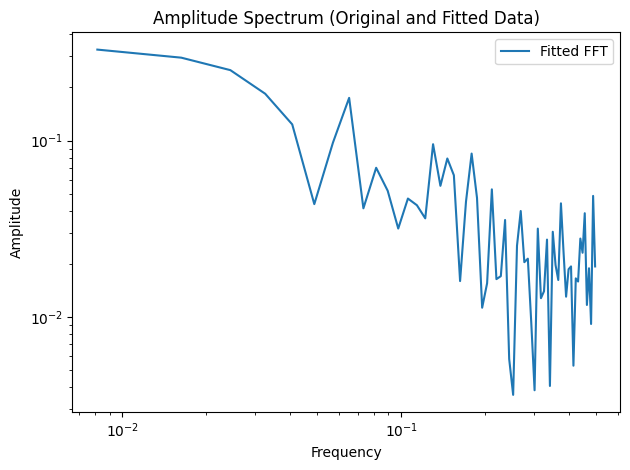

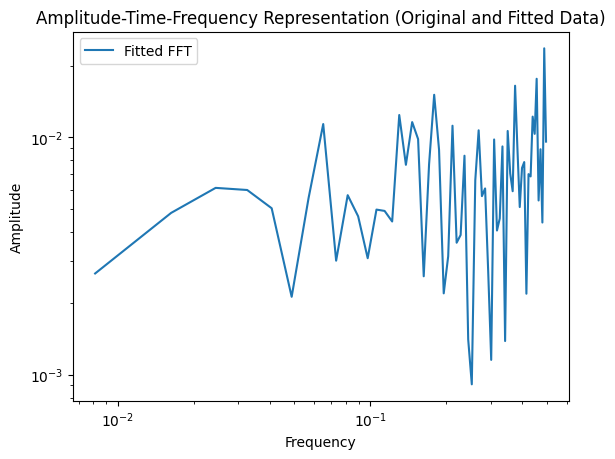

kernals: 1**2 * RBF(length_scale=0.14) + 1**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.01)
Number of training data points: 123
final values of the kernals are: 0.0199**2 * RBF(length_scale=0.14) + 3.77**2 * Matern(length_scale=14.3, nu=1.5) + WhiteKernel(noise_level=0.000323)
log_likelihood= -97.29531346990353
training datapoint 123
K 5
a= 194.59062693980707
aa= 24.060921776862084
Bayesian Information Criterion (BIC): 218.65154871666914
AIC= 204.59062693980707
(2 * k * (k + 1))= 60
(n - k - 1)= 117
Corrected Akaike Information Criterion (AICc): 2.261458349912881
starting


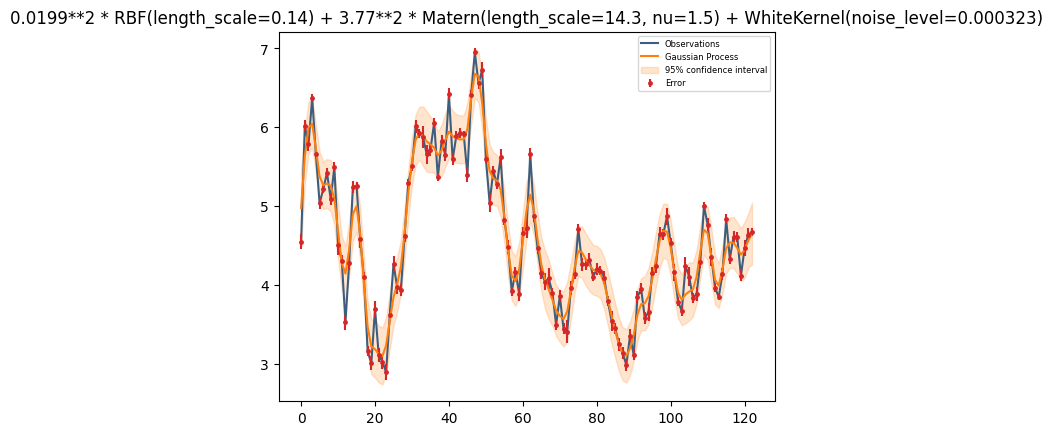

<ipython-input-68-322490e2b774>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


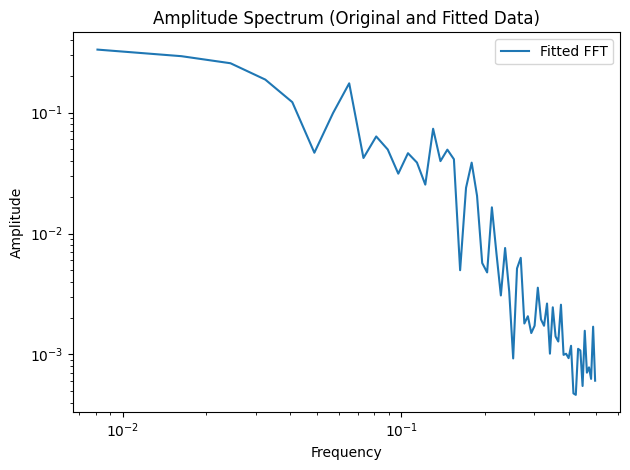

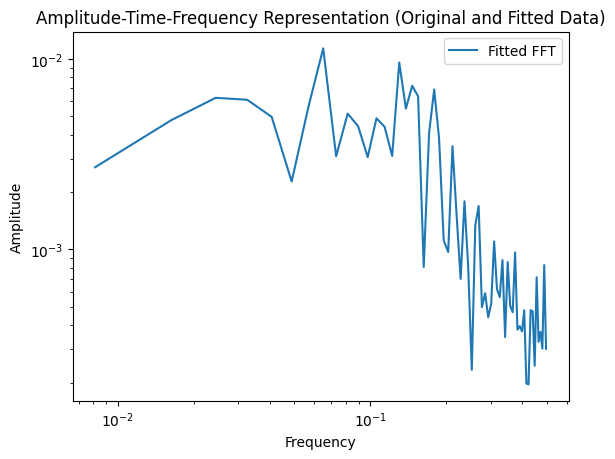

kernals: 1**2 * RBF(length_scale=0.24) + 1**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)
Number of training data points: 123
final values of the kernals are: 3.83**2 * RBF(length_scale=18) + 0.424**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.0121)
log_likelihood= -119.00080663246949
training datapoint 123
K 5
a= 238.00161326493898
aa= 24.060921776862084
Bayesian Information Criterion (BIC): 262.0625350418011
AIC= 248.00161326493898
(2 * k * (k + 1))= 60
(n - k - 1)= 117
Corrected Akaike Information Criterion (AICc): 2.632492421067855
starting


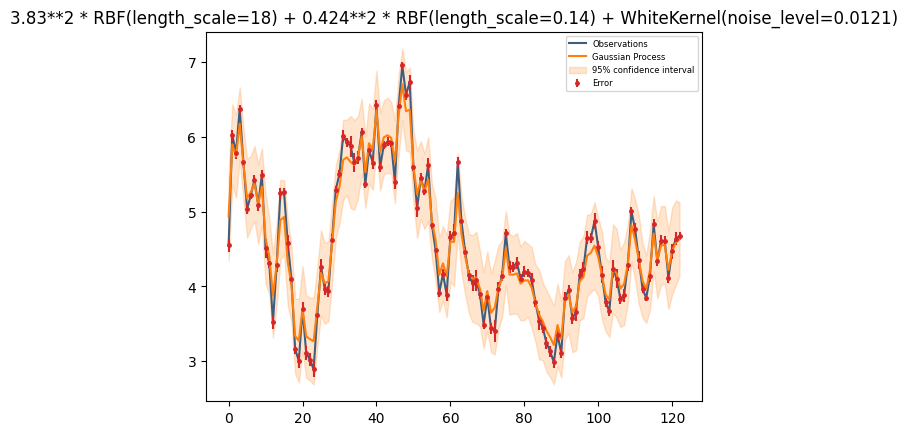

<ipython-input-68-322490e2b774>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


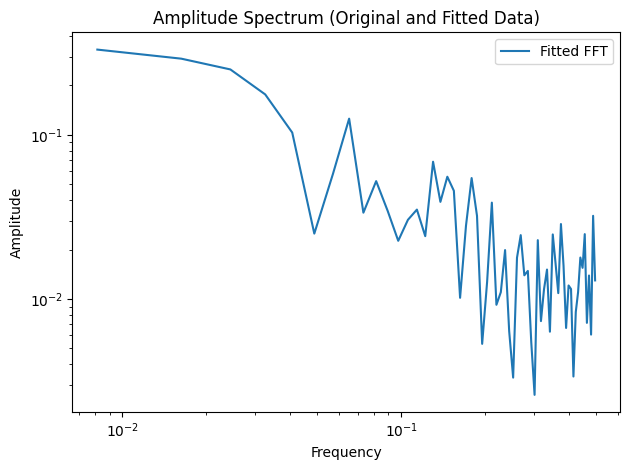

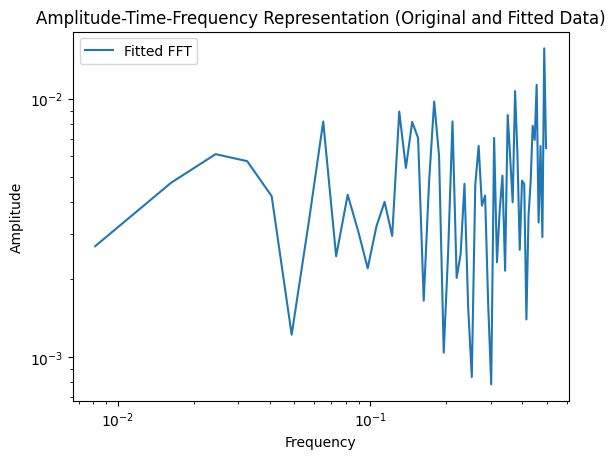

kernals: 1**2 * RBF(length_scale=0.1) + ExpSineSquared(length_scale=0.1, periodicity=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 123
final values of the kernals are: 0.816**2 * RBF(length_scale=0.1) + ExpSineSquared(length_scale=0.1, periodicity=0.1) + WhiteKernel(noise_level=0.00996)
log_likelihood= -171.65552135122982
training datapoint 123
K 5
a= 343.31104270245964
aa= 24.060921776862084
Bayesian Information Criterion (BIC): 367.3719644793217
AIC= 353.31104270245964
(2 * k * (k + 1))= 60
(n - k - 1)= 117
Corrected Akaike Information Criterion (AICc): 3.532573014550937
starting


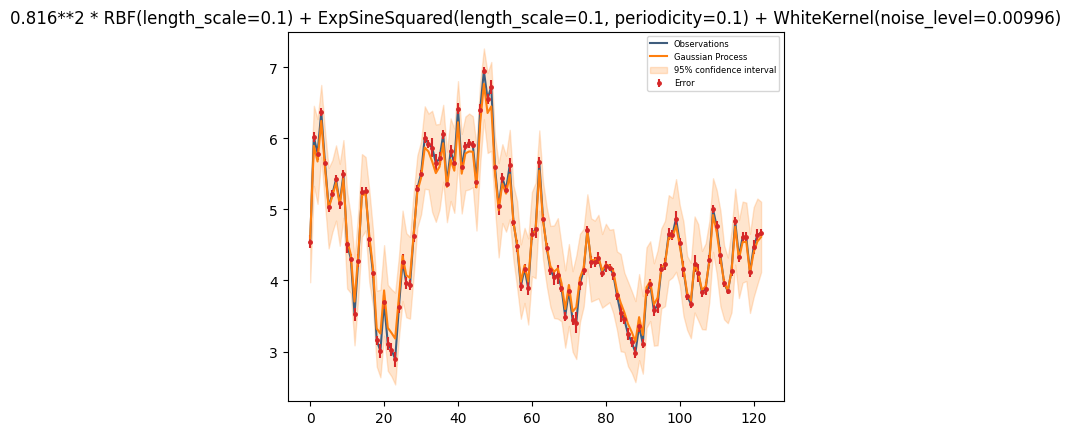

<ipython-input-68-322490e2b774>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


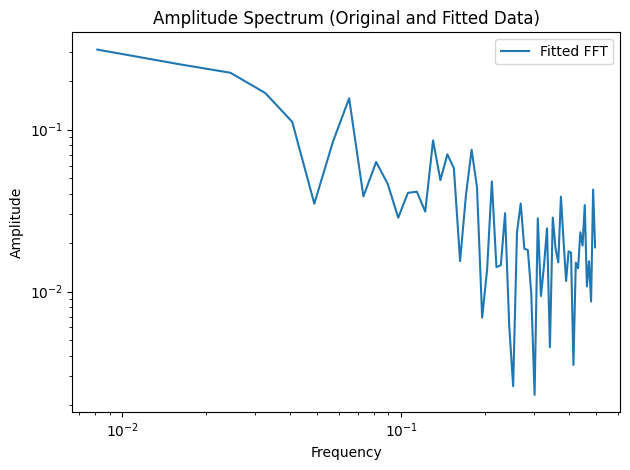

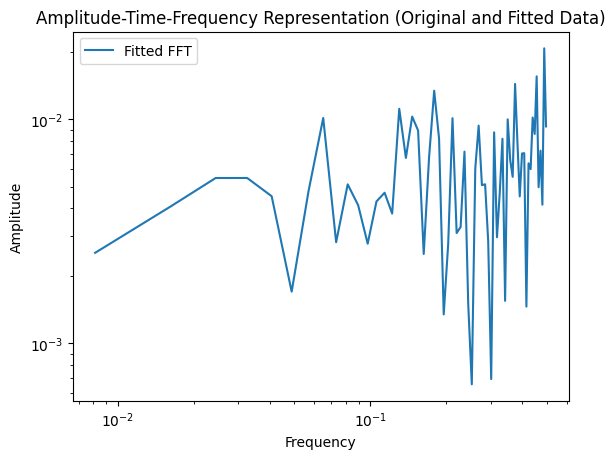

kernals: 1**2 * RBF(length_scale=0.4) + ExpSineSquared(length_scale=0.0001, periodicity=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 123
final values of the kernals are: 1**2 * RBF(length_scale=0.4) + ExpSineSquared(length_scale=0.0001, periodicity=0.1) + WhiteKernel(noise_level=0.01)
log_likelihood= -172.39885847817914
training datapoint 123
K 5
a= 344.7977169563583
aa= 24.060921776862084
Bayesian Information Criterion (BIC): 368.85863873322035
AIC= 354.7977169563583
(2 * k * (k + 1))= 60
(n - k - 1)= 117
Corrected Akaike Information Criterion (AICc): 3.5452796321056264
starting


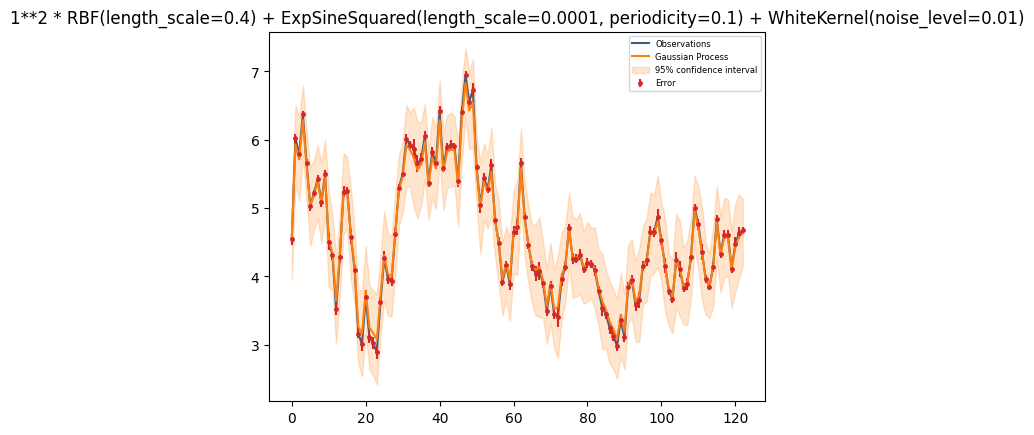

<ipython-input-68-322490e2b774>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


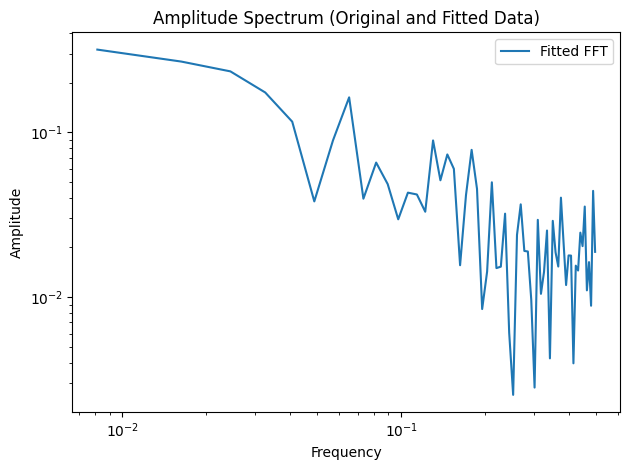

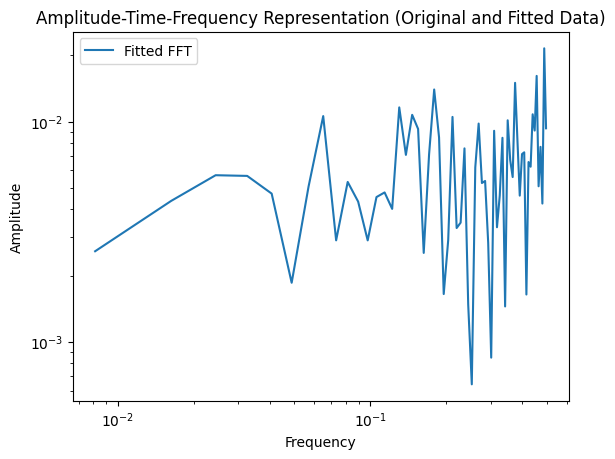

kernals: 1**2 * RBF(length_scale=0.4) + 1**2 * RBF(length_scale=0.2) + 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 123
final values of the kernals are: 3.61**2 * RBF(length_scale=8.1) + 0.193**2 * RBF(length_scale=0.2) + 0.193**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.0118)
log_likelihood= -111.57605295622804
training datapoint 123
K 7
a= 223.15210591245608
aa= 33.68529048760692
Bayesian Information Criterion (BIC): 256.83739640006297
AIC= 237.15210591245608
(2 * k * (k + 1))= 112
(n - k - 1)= 115
Corrected Akaike Information Criterion (AICc): 3.036105268803966
starting


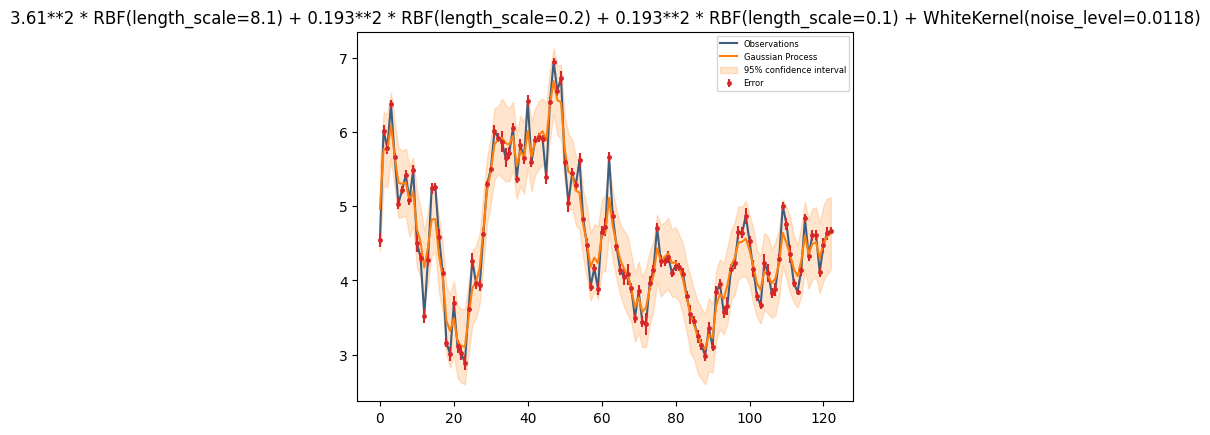

<ipython-input-68-322490e2b774>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


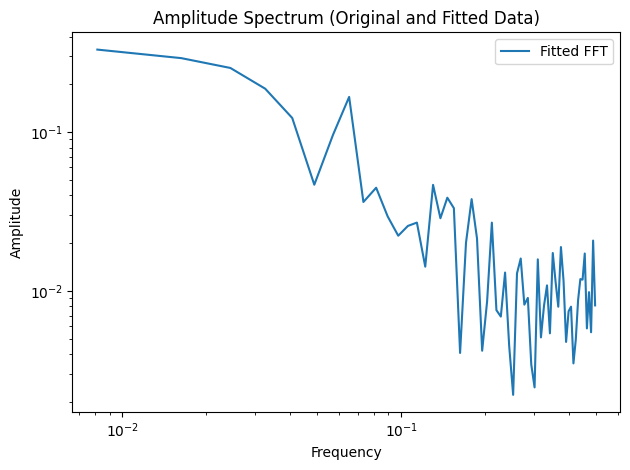

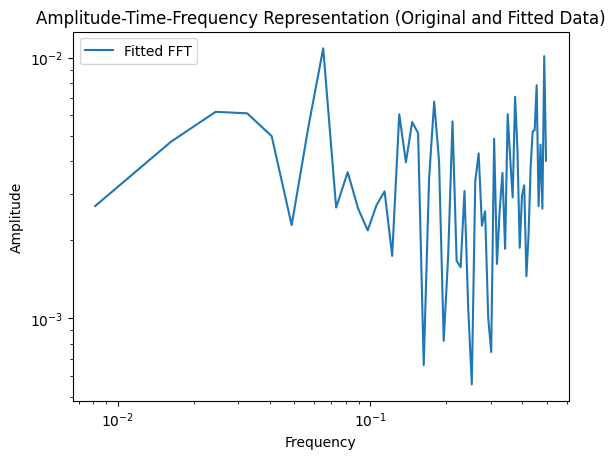

In [68]:
# Plotting
for i, kernel in enumerate(kernels):
  print('kernals:',kernel)
  fig, box1 = plt.subplots()
  t, y, y_error,juldate_min = load_data(data_files[0])
  juldate_zero, gpr, log_likelihood, final_kernal_value, gpr_kernel_theta, num_training_data, X = Gaussian_process(t, y, y_error, box1,kernel)  # process and plot the first data file on the first axes object
  BIC, AICc, no_parameter = compute_model(num_training_data,gpr_kernel_theta,log_likelihood)
  y_pred, sigma = gpr.predict(X, return_std=True)
  plot_results(t, y, y_error, y_pred, sigma, box1, X)
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)
  print(juldate_zero)


  # Perform FFT analysis for the original data
 # positive_freqs, amplitude_original, _ = compute_fft(t, y)
  fig, b1 = plt.subplots()
  #b1.plot(positive_freqs, amplitude_original, label='Original FFT')

  # Calculate the FFT of the Gaussian Process fitted curve (y_pred)
  positive_freqs_fitted, amplitude_fitted, _ = compute_fft(t, y_pred.flatten())
  b1.plot(positive_freqs_fitted, amplitude_fitted, label='gaussian value Fitted FFT')
  plt.xscale('log')  # Set x-axis to logarithmic scale
  plt.yscale('log')  # Set y-axis to logarithmic scale
  b1.set_title('Amplitude Spectrum (Original and Fitted Data)')
  b1.set_xlabel('Frequency')
  b1.set_ylabel('Amplitude')
  b1.legend()

  plt.tight_layout()
  plt.show()

  plt.figure()

  # Plot the amplitude-time-frequency representation with logarithmic y-axis
  plt.plot(positive_freqs_fitted, (positive_freqs_fitted*amplitude_fitted), label='gaussian value Fitted FFT')
  plt.xscale('log')
  plt.yscale('log')  # Set y-axis to logarithmic scale
  plt.title('Amplitude-Time-Frequency Representation (Original and Fitted Data)')
  plt.xlabel('Frequency')
  plt.ylabel('Amplitude')
  plt.legend()

  plt.show()


In [52]:
Result_Table_box1.to_csv("gp_Result_Table_box1.csv")
Result_Table_box1

,Kernel,k,log likelihood,BIC,AICc
0,4.63**2 * RBF(length_scale=0.14) + WhiteKernel...,3,-363.996789,742.430132,6.369694
1,3.29**2 * RBF(length_scale=0.14) + 3.29**2 * R...,5,-363.996789,752.054500,6.820458
2,0.0199**2 * RBF(length_scale=0.14) + 3.77**2 *...,5,-97.295313,218.651549,2.261458
3,3.83**2 * RBF(length_scale=18) + 0.424**2 * RB...,5,-119.000807,262.062535,2.632492
4,0.816**2 * RBF(length_scale=0.1) + ExpSineSqua...,5,-171.655521,367.371964,3.532573
5,1**2 * RBF(length_scale=0.4) + ExpSineSquared(...,5,-172.398858,368.858639,3.545280
6,3.61**2 * RBF(length_scale=8.1) + 0.193**2 * R...,7,-111.576053,256.837396,3.036105


In [53]:
'''def combine_data_files_with_random_values(data_files):
    data_combined = np.array([])  # initialize an empty numpy array
    rand = np.array([])
    for idx, data_file in enumerate(data_files):
        data = np.genfromtxt(data_file)  # load data from a file into a numpy array
        if data_combined.size == 0:  # if the combined data array is still empty
            data_combined = data  # set the combined data array to the data array
        else:  # if the combined data array is not empty
            # Generate 10 random values between the last value of data_combined[:, 1] and the first value of data[:, 1]
            last_value = data_combined[-1, 1]
            first_value = data[0, 1]
            random_values = np.random.uniform(last_value, first_value, 100)
            rand = np.concatenate((rand, random_values))

            # Create a new array with nan values for all columns except column 1 (index 1)
            num_columns = data.shape[1]
            nan_values = np.full((100, num_columns), np.nan)  # Change the shape to (10, num_columns)
            nan_values[:, 1] = random_values

            # Concatenate the random values between the two files
            data_combined = np.concatenate((data_combined, nan_values, data))

    return data_combined, rand  # return the combined data array
    '''

'def combine_data_files_with_random_values(data_files):\n    data_combined = np.array([])  # initialize an empty numpy array\n    rand = np.array([])\n    for idx, data_file in enumerate(data_files):\n        data = np.genfromtxt(data_file)  # load data from a file into a numpy array\n        if data_combined.size == 0:  # if the combined data array is still empty\n            data_combined = data  # set the combined data array to the data array\n        else:  # if the combined data array is not empty\n            # Generate 10 random values between the last value of data_combined[:, 1] and the first value of data[:, 1]\n            last_value = data_combined[-1, 1]\n            first_value = data[0, 1]\n            random_values = np.random.uniform(last_value, first_value, 100)\n            rand = np.concatenate((rand, random_values))\n\n            # Create a new array with nan values for all columns except column 1 (index 1)\n            num_columns = data.shape[1]\n            nan

In [54]:
def combine_data_files_with_random_values(data_files):
    data_combined = np.array([])  # initialize an empty numpy array
    rand = np.array([])
    for idx, data_file in enumerate(data_files):
        data = np.genfromtxt(data_file)  # load data from a file into a numpy array
        if data_combined.size == 0:  # if the combined data array is still empty
            data_combined = data  # set the combined data array to the data array
        else:  # if the combined data array is not empty
            # Generate 10 random values in ascending order between the last value of data_combined[:, 1] and the first value of data[:, 1]
            last_value = data_combined[-1, 1]
            first_value = data[0, 1]
            random_values = np.linspace(last_value, first_value, 100, endpoint=False)
            rand = np.concatenate((rand, random_values))

            # Create a new array with nan values for all columns except column 1 (index 1)
            num_columns = data.shape[1]
            nan_values = np.full((100, num_columns), np.nan)  # Change the shape to (10, num_columns)
            nan_values[:, 1] = random_values

            # Concatenate the random values between the two files
            data_combined = np.concatenate((data_combined, nan_values, data))

    return data_combined, rand  # return the combined data array


In [55]:
# Function to combine data from multiple files
def combine_data_files(data_files):
  data_combined = np.array([])  # initialize an empty numpy array
  for data_file in data_files:
    data = np.genfromtxt(data_file)  # load data from a file into a numpy array
    if data_combined.size == 0: # if the combined data array is still empty
      data_combined = data  # set the combined data array to the data array
    else:  # if the combined data array is not empty

      data_combined = np.concatenate((data_combined, data))  # concatenate the data array to the combined data array
  return data_combined  # return the combined data array


In [56]:
# Combine the data files
data_combined = combine_data_files(data_files[1:-1])
np.savetxt('fvar_soft_dt1000_combined.dat', data_combined)
np.savetxt('fvar_soft_dt1000_combined.csv', data_combined)
data_combined

array([[5.000000e+00, 5.354649e+08, 3.064027e+00, 1.352398e-01,
        3.972612e-03],
       [1.005000e+03, 5.354659e+08, 2.481655e+00, 1.027394e-01,
        3.345357e-03],
       [2.005000e+03, 5.354669e+08, 2.747491e+00, 9.423223e-02,
        2.509018e-03],
       ...,
       [1.230050e+05, 5.361006e+08, 2.816659e+00, 1.024327e-01,
        7.341176e-03],
       [1.240050e+05, 5.361016e+08, 2.894988e+00, 1.004270e-01,
        1.101176e-02],
       [1.250050e+05, 5.361026e+08, 2.842698e+00, 8.763326e-02,
        5.301961e-03]])

In [57]:
# Combine the data files
data_combined, r= combine_data_files_with_random_values(data_files[1:-1])
np.savetxt('fvar_soft_dt1000_combined_with_values.dat', data_combined)
np.savetxt('fvar_soft_dt1000_combined_values.csv', data_combined)
r

array([5.35580900e+08, 5.35581457e+08, 5.35582014e+08, 5.35582571e+08,
       5.35583128e+08, 5.35583685e+08, 5.35584242e+08, 5.35584799e+08,
       5.35585356e+08, 5.35585913e+08, 5.35586470e+08, 5.35587027e+08,
       5.35587584e+08, 5.35588141e+08, 5.35588698e+08, 5.35589255e+08,
       5.35589812e+08, 5.35590369e+08, 5.35590926e+08, 5.35591483e+08,
       5.35592040e+08, 5.35592597e+08, 5.35593154e+08, 5.35593711e+08,
       5.35594268e+08, 5.35594825e+08, 5.35595382e+08, 5.35595939e+08,
       5.35596496e+08, 5.35597053e+08, 5.35597610e+08, 5.35598167e+08,
       5.35598724e+08, 5.35599281e+08, 5.35599838e+08, 5.35600395e+08,
       5.35600952e+08, 5.35601509e+08, 5.35602066e+08, 5.35602623e+08,
       5.35603180e+08, 5.35603737e+08, 5.35604294e+08, 5.35604851e+08,
       5.35605408e+08, 5.35605965e+08, 5.35606522e+08, 5.35607079e+08,
       5.35607636e+08, 5.35608193e+08, 5.35608750e+08, 5.35609307e+08,
       5.35609864e+08, 5.35610421e+08, 5.35610978e+08, 5.35611535e+08,
      

In [58]:
Result_Table_box2 = pd.DataFrame(columns=['Kernel', 'k','log_likelihood','BIC', 'AICc'])

kernals: 1**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)
Number of training data points: 481
final values of the kernals are: 3.25**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.313)
log_likelihood= -1257.8290964835849
training datapoint 481
K 3
a= 2515.6581929671697
aa= 18.527601810317282
Bayesian Information Criterion (BIC): 2534.185794777487
AIC= 2521.6581929671697
(2 * k * (k + 1))= 24
(n - k - 1)= 477
Corrected Akaike Information Criterion (AICc): 5.336809628861991
Ypred= [2.93905512e+000 2.38749954e+000 2.64530415e+000 2.44190418e+000
 2.57116409e+000 2.40751597e+000 2.70443998e+000 2.63281236e+000
 2.71545900e+000 2.49216675e+000 2.59131781e+000 2.80868340e+000
 2.83553289e+000 3.03255291e+000 2.98062850e+000 2.62820136e+000
 3.10816865e+000 2.64553143e+000 2.11099590e+000 2.44087493e+000
 2.41944645e+000 2.30985759e+000 2.57036941e+000 2.56389120e+000
 2.57402054e+000 2.90645430e+000 2.80659189e+000 2.51356846e+000
 2.44264341e+000 2.57812430e+000 3.02213

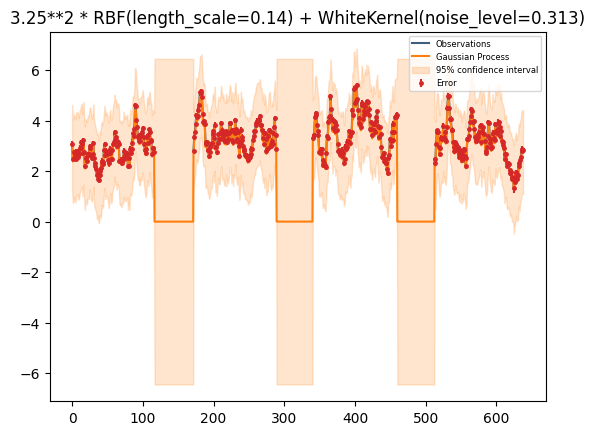

<ipython-input-61-ee88b1f93504>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


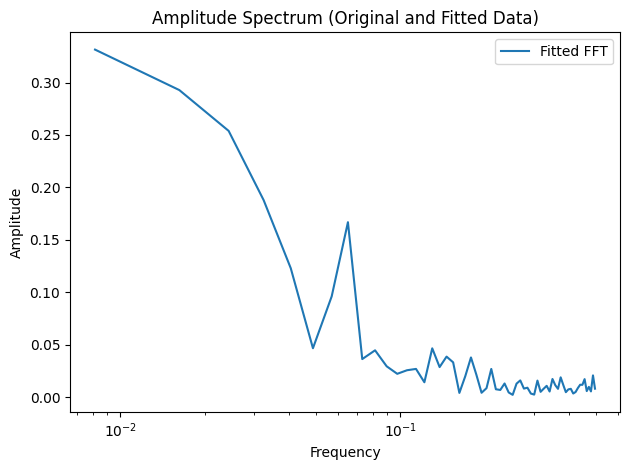

kernals: 1**2 * RBF(length_scale=0.14) + 1**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=0.01)
Number of training data points: 481
final values of the kernals are: 2.33**2 * RBF(length_scale=0.14) + 2.33**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=0.0205)
log_likelihood= -1257.8290964854405
training datapoint 481
K 5
a= 2515.658192970881
aa= 30.879336350528806
Bayesian Information Criterion (BIC): 2546.5375293214097
AIC= 2525.658192970881
(2 * k * (k + 1))= 60
(n - k - 1)= 475
Corrected Akaike Information Criterion (AICc): 5.443490932570276
Ypred= [3.02058504e+000 2.45372921e+000 2.71868537e+000 2.50964305e+000
 2.64248865e+000 2.47430090e+000 2.77946164e+000 2.70584706e+000
 2.79078632e+000 2.56129991e+000 2.66320143e+000 2.88659679e+000
 2.91419109e+000 3.11667648e+000 3.06331168e+000 2.70110814e+000
 3.19438981e+000 2.71891895e+000 2.16955531e+000 2.50858525e+000
 2.48656233e+000 2.37393346e+000 2.64167193e+000 2.63501401e+000
 2.64542434e+000 2.98707987e+000 2.884

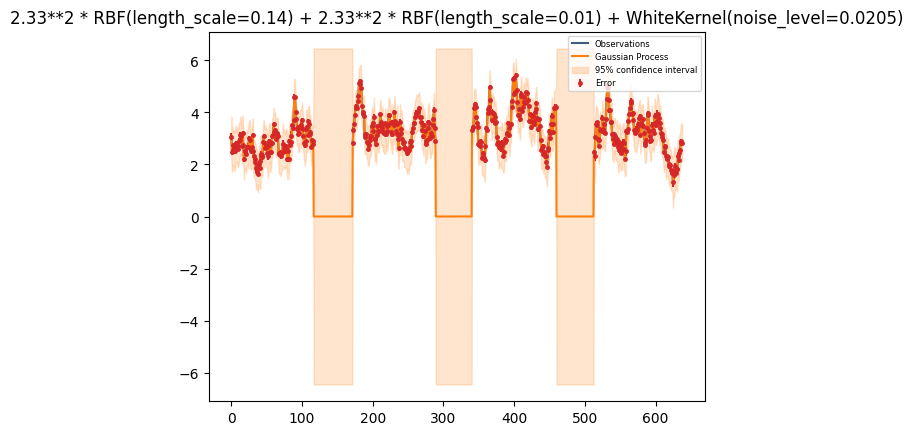

<ipython-input-61-ee88b1f93504>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


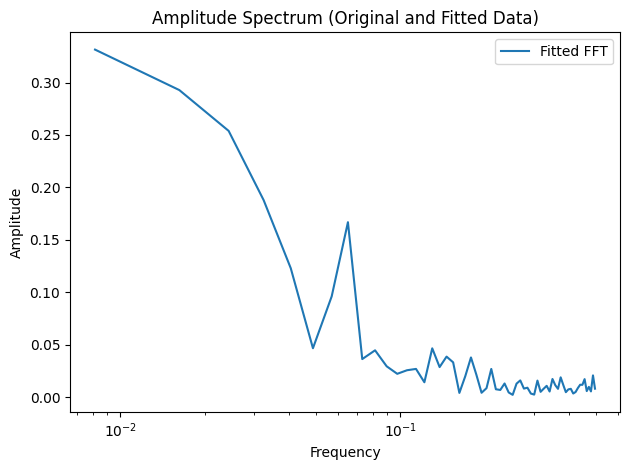

kernals: 1**2 * RBF(length_scale=0.14) + 1**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.01)
Number of training data points: 481
final values of the kernals are: 2.33**2 * RBF(length_scale=0.14) + 2.33**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.0205)
log_likelihood= -1257.828963131627
training datapoint 481
K 5
a= 2515.657926263254
aa= 30.879336350528806
Bayesian Information Criterion (BIC): 2546.537262613783
AIC= 2525.657926263254
(2 * k * (k + 1))= 60
(n - k - 1)= 475
Corrected Akaike Information Criterion (AICc): 5.443490371080535
Ypred= [3.02058537e+000 2.45372943e+000 2.71868559e+000 2.50964329e+000
 2.64248885e+000 2.47430111e+000 2.77946186e+000 2.70584723e+000
 2.79078652e+000 2.56130007e+000 2.66320169e+000 2.88659705e+000
 2.91419128e+000 3.11667674e+000 3.06331193e+000 2.70110835e+000
 3.19439004e+000 2.71891921e+000 2.16955552e+000 2.50858540e+000
 2.48656254e+000 2.37393364e+000 2.64167212e+000 2.63501418e+000
 2.64542463e+000 2.9

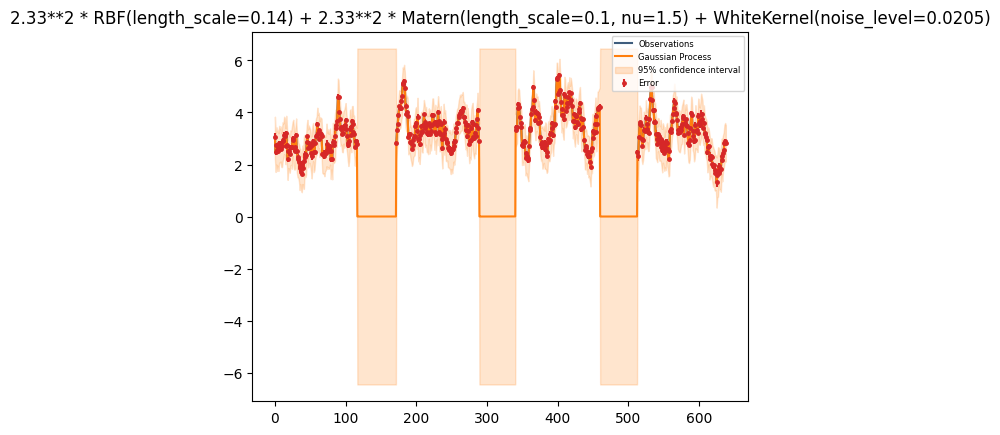

<ipython-input-61-ee88b1f93504>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


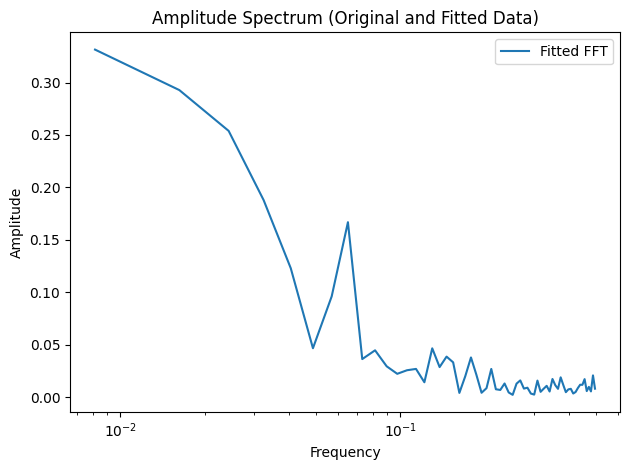

kernals: 1**2 * RBF(length_scale=0.24) + 1**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)
Number of training data points: 481


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 2.49**2 * RBF(length_scale=8.34) + 0.00316**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=1e-05)
log_likelihood= -248.5209605030803
training datapoint 481
K 5
a= 497.0419210061606
aa= 30.879336350528806
Bayesian Information Criterion (BIC): 527.9212573566894
AIC= 507.0419210061606
(2 * k * (k + 1))= 60
(n - k - 1)= 475
Corrected Akaike Information Criterion (AICc): 1.1937724652761275
Ypred= [ 2.76394276e+00  2.71643438e+00  2.66951754e+00  2.63230779e+00
  2.61233447e+00  2.61419692e+00  2.63917828e+00  2.68469420e+00
  2.74490398e+00  2.81124382e+00  2.87393584e+00  2.92315547e+00
  2.95078018e+00  2.95174994e+00  2.92485156e+00  2.87318882e+00
  2.80395674e+00  2.72694635e+00  2.65375518e+00  2.59556976e+00
  2.56122534e+00  2.55592311e+00  2.58014573e+00  2.62913932e+00
  2.69364320e+00  2.76098188e+00  2.81671962e+00  2.84708342e+00
  2.84089788e+00  2.79148271e+00  2.69788300e+00  2.56519452e+00
  2.40469540e+00  2.23200925e+00  2.06544390e+

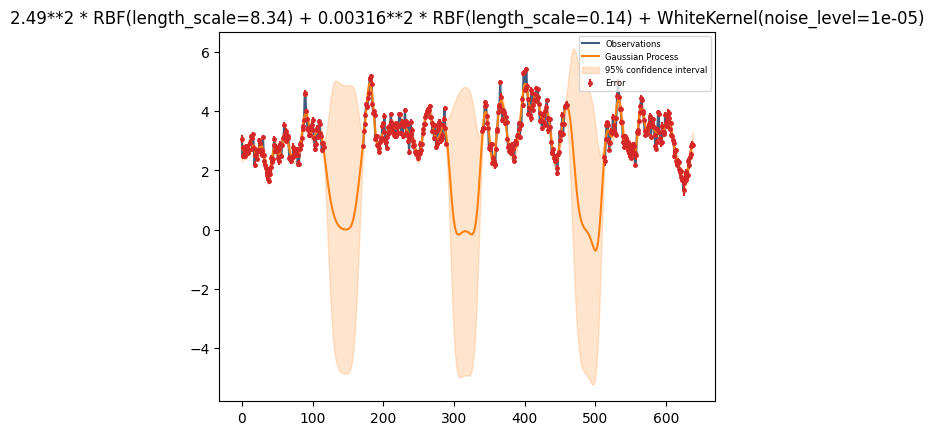

<ipython-input-61-ee88b1f93504>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


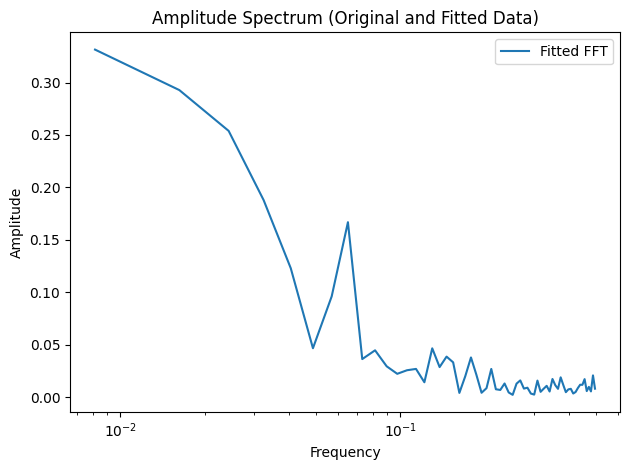

kernals: 1**2 * RBF(length_scale=0.1) + ExpSineSquared(length_scale=0.1, periodicity=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 481
final values of the kernals are: 0.556**2 * RBF(length_scale=0.1) + ExpSineSquared(length_scale=0.1, periodicity=0.1) + WhiteKernel(noise_level=0.00887)
log_likelihood= -479.4724627757842
training datapoint 481
K 5
a= 958.9449255515684
aa= 30.879336350528806
Bayesian Information Criterion (BIC): 989.8242619020972
AIC= 968.9449255515684
(2 * k * (k + 1))= 60
(n - k - 1)= 475
Corrected Akaike Information Criterion (AICc): 2.1661998432664595
Ypred= [ 2.91033664e+00  2.50926711e+00  2.70815373e+00  2.55546196e+00
  2.65221944e+00  2.52711019e+00  2.75956786e+00  2.70515834e+00
  2.77275688e+00  2.59087018e+00  2.67659871e+00  2.84251307e+00
  2.87642983e+00  3.02165645e+00  2.98397929e+00  2.70947603e+00
  3.09681140e+00  2.72618437e+00  2.32693527e+00  2.55650675e+00
  2.55429023e+00  2.46194590e+00  2.66977500e+00  2.66305424e+00
  

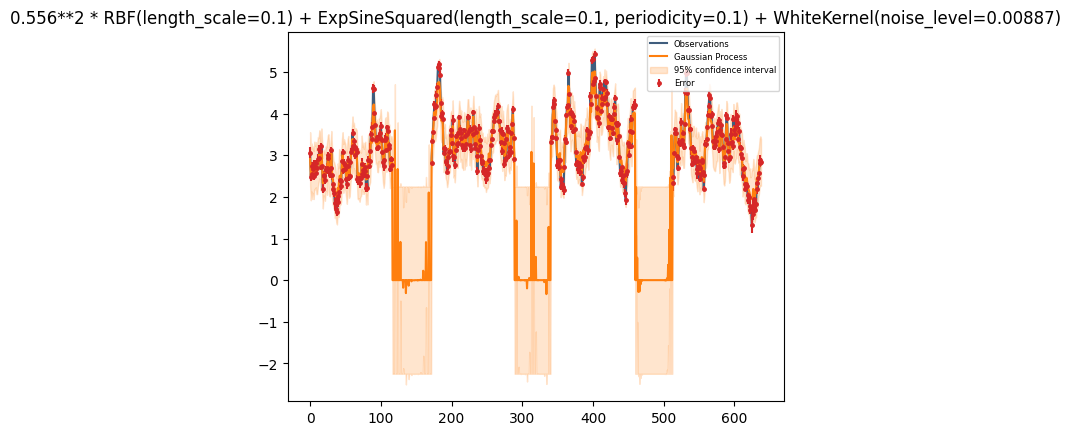

<ipython-input-61-ee88b1f93504>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


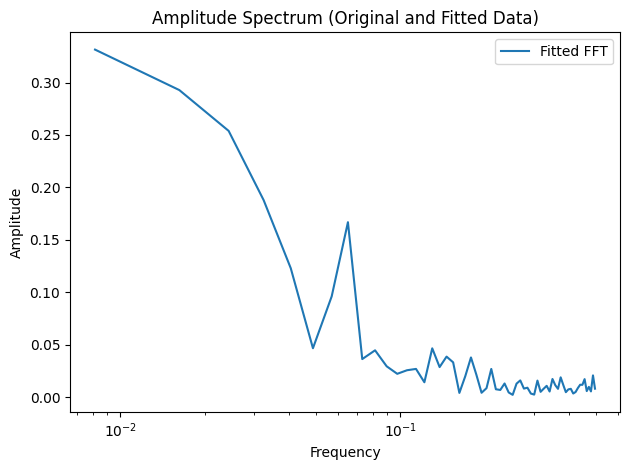

kernals: 1**2 * RBF(length_scale=0.4) + ExpSineSquared(length_scale=0.0001, periodicity=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 481
final values of the kernals are: 1**2 * RBF(length_scale=0.4) + ExpSineSquared(length_scale=0.0001, periodicity=0.1) + WhiteKernel(noise_level=0.01)
log_likelihood= -560.0298787930519
training datapoint 481
K 5
a= 1120.0597575861038
aa= 30.879336350528806
Bayesian Information Criterion (BIC): 1150.9390939366326
AIC= 1130.0597575861038
(2 * k * (k + 1))= 60
(n - k - 1)= 475
Corrected Akaike Information Criterion (AICc): 2.505388963339166
Ypred= [ 3.00194485e+000  2.49462885e+000  2.73182726e+000  2.54696155e+000
  2.66151093e+000  2.51178337e+000  2.78963636e+000  2.72082330e+000
  2.80025782e+000  2.58639459e+000  2.68932203e+000  2.89169939e+000
  2.91841702e+000  3.10420392e+000  3.05537049e+000  2.72404851e+000
  3.17745654e+000  2.74256768e+000  2.24637486e+000  2.53718786e+000
  2.52744639e+000  2.42058657e+000  2.66647809

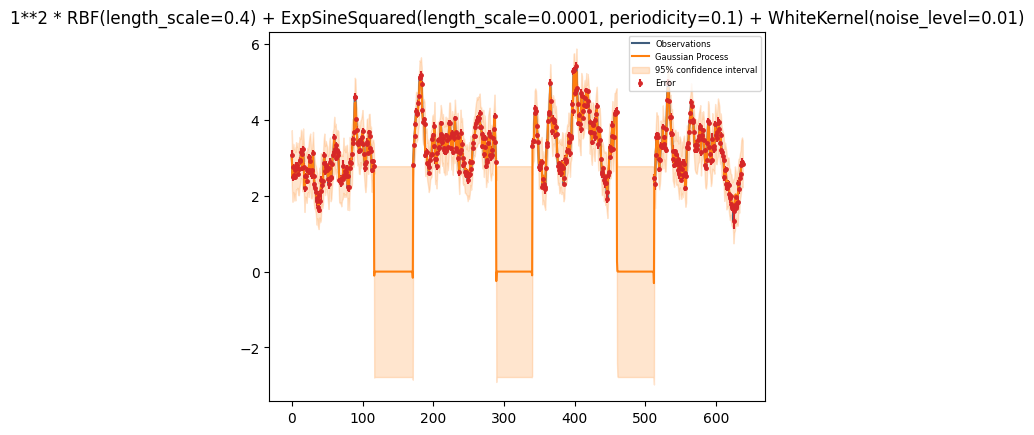

<ipython-input-61-ee88b1f93504>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


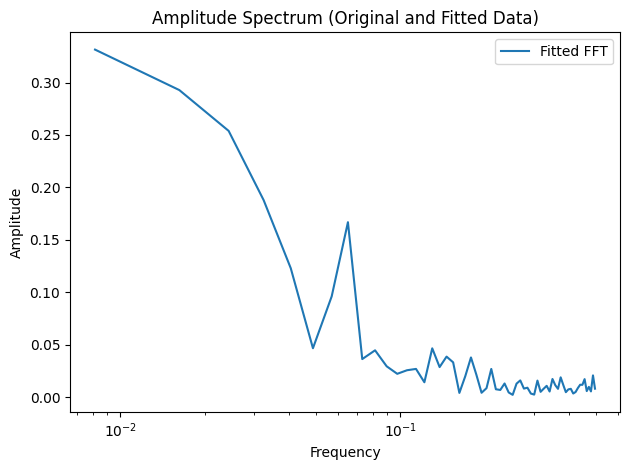

kernals: 1**2 * RBF(length_scale=0.4) + 1**2 * RBF(length_scale=0.2) + 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 481


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 2.49**2 * RBF(length_scale=8.34) + 0.00316**2 * RBF(length_scale=0.196) + 0.00316**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=1e-05)
log_likelihood= -248.52349703419324
training datapoint 481
K 7
a= 497.0469940683865
aa= 43.23107089074033
Bayesian Information Criterion (BIC): 540.2780649591268
AIC= 511.0469940683865
(2 * k * (k + 1))= 112
(n - k - 1)= 473
Corrected Akaike Information Criterion (AICc): 1.3172240889395064
Ypred= [ 2.76396181e+00  2.71640693e+00  2.66952171e+00  2.63229732e+00
  2.61234158e+00  2.61418832e+00  2.63920223e+00  2.68470669e+00
  2.74491883e+00  2.81121512e+00  2.87392120e+00  2.92315321e+00
  2.95077357e+00  2.95176347e+00  2.92486154e+00  2.87316341e+00
  2.80400270e+00  2.72694479e+00  2.65371333e+00  2.59556231e+00
  2.56122541e+00  2.55591061e+00  2.58016301e+00  2.62914847e+00
  2.69364492e+00  2.76101528e+00  2.81672288e+00  2.84705548e+00
  2.84085317e+00  2.79146099e+00  2.69792779e+00  2.56517869e+00
  2.404

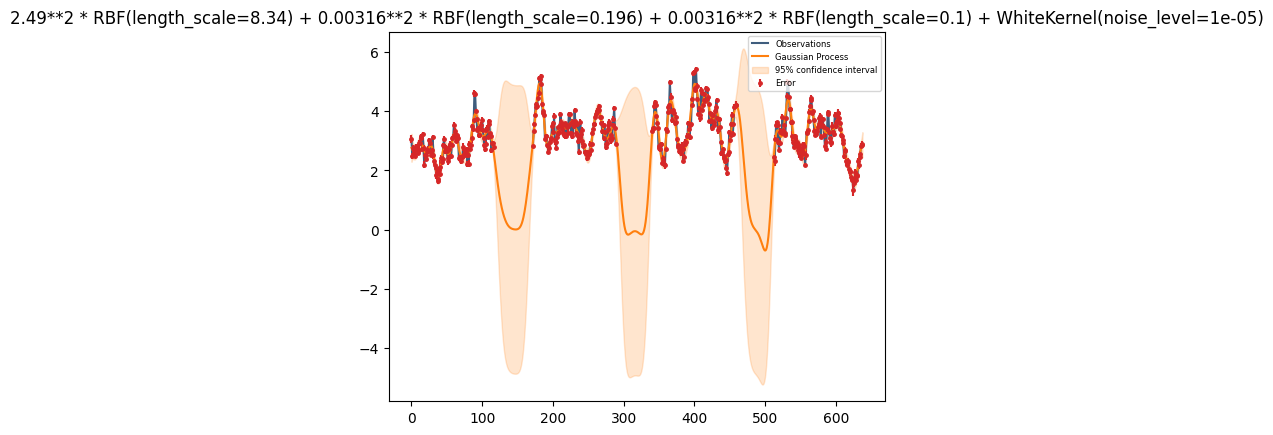

<ipython-input-61-ee88b1f93504>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


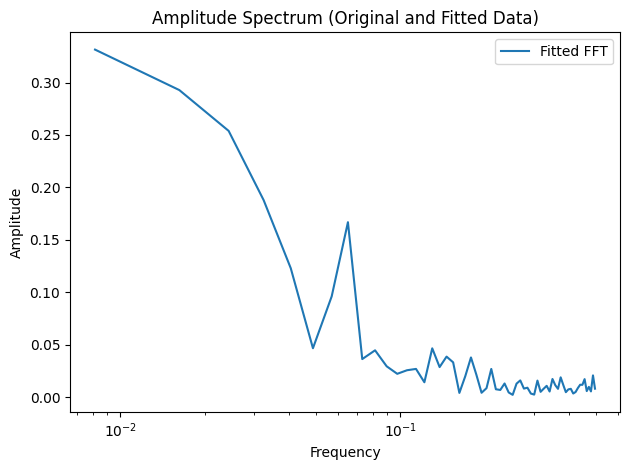

In [61]:
for i, kernel in enumerate(kernels):
  print('kernals:',kernel)# create the figure and the first axes object
  t, y, y_error,juldate_min_1 = load_data('fvar_soft_dt1000_combined.dat')
  x1= t.reshape(-1, 1)
  juldate_zero, gpr, log_likelihood, final_kernal_value, gpr_kernel_theta, num_training_data, X = Gaussian_process(t, y, y_error, box1,kernel)  # process and plot the first data file on the first axes object
  BIC, AICc, no_parameter = compute_model(num_training_data,gpr_kernel_theta,log_likelihood)
  t1, y1, y_error_1,juldate_min_2 = load_data('fvar_soft_dt1000_combined_with_values.dat')
  x= t1.reshape(-1, 1)
  y_preds, sigma = gpr.predict(x, return_std=True)
  print("Ypred=",y_preds.flatten())
  df= pd.DataFrame()
  df['X']=x.flatten()
  df['y_pred']= y_preds.flatten()
  box = plt.subplot()
  # Call the plot_results function to plot the results
  plot_results(t1, y1, y_error_1, y_preds, sigma, box, x, col1=col1, col2=col2)
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)
  '''
  # Perform FFT analysis for the original data
  positive_freqs, amplitude_original, _ = compute_fft(t, y)

  b2.plot(positive_freqs, amplitude_original, label='Original FFT')
  '''
  # Calculate the FFT of the Gaussian Process fitted curve (y_pred)
  positive_freqs_fitted, amplitude_fitted, _ = compute_fft(x, y_pred.flatten())
  fig, b2 = plt.subplots()
  b2.plot(positive_freqs_fitted, amplitude_fitted, label='Fitted FFT')
  plt.xscale('log')
  b2.set_title('Amplitude Spectrum (Original and Fitted Data)')
  b2.set_xlabel('Frequency')
  b2.set_ylabel('Amplitude')
  b2.legend()

  plt.tight_layout()
  plt.show()


In [62]:
Result_Table_box2

,Kernel,k,log_likelihood,BIC,AICc
0,3.25**2 * RBF(length_scale=0.14) + WhiteKernel...,3,-1257.829096,2534.185795,5.336810
1,2.33**2 * RBF(length_scale=0.14) + 2.33**2 * R...,5,-1257.829096,2546.537529,5.443491
2,2.33**2 * RBF(length_scale=0.14) + 2.33**2 * M...,5,-1257.828963,2546.537263,5.443490
3,2.49**2 * RBF(length_scale=8.34) + 0.00316**2 ...,5,-248.520961,527.921257,1.193772
4,0.556**2 * RBF(length_scale=0.1) + ExpSineSqua...,5,-479.472463,989.824262,2.166200
5,1**2 * RBF(length_scale=0.4) + ExpSineSquared(...,5,-560.029879,1150.939094,2.505389
6,2.49**2 * RBF(length_scale=8.34) + 0.00316**2 ...,7,-248.523497,540.278065,1.317224
7,3.25**2 * RBF(length_scale=0.14) + WhiteKernel...,3,-1257.829096,2534.185795,5.336810
8,2.33**2 * RBF(length_scale=0.14) + 2.33**2 * R...,5,-1257.829096,2546.537529,5.443491
9,2.33**2 * RBF(length_scale=0.14) + 2.33**2 * M...,5,-1257.828963,2546.537263,5.443490


In [63]:
Result_Table_box3 = pd.DataFrame(columns=['Kernel', 'k','log_likelihood','BIC', 'AICc'])

kernals: 1**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)
Number of training data points: 118
final values of the kernals are: 2.89**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.0197)
log_likelihood= -293.53238039407586
training datapoint 118
K 3
a= 587.0647607881517
aa= 14.312053873396994
Bayesian Information Criterion (BIC): 601.3768146615487
AIC= 593.0647607881517
(2 * k * (k + 1))= 24
(n - k - 1)= 114
Corrected Akaike Information Criterion (AICc): 5.412848778843436
starting


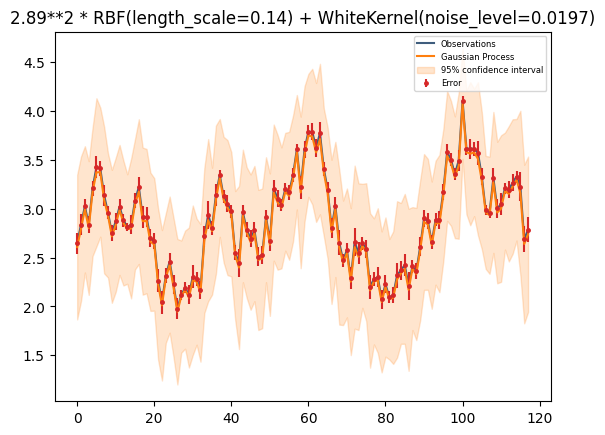

<ipython-input-64-5376ba1a9377>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


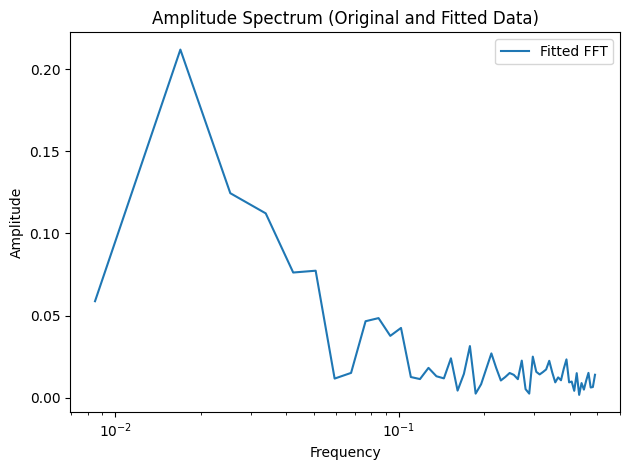

kernals: 1**2 * RBF(length_scale=0.14) + 1**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=0.01)
Number of training data points: 118
final values of the kernals are: 2.05**2 * RBF(length_scale=0.14) + 2.05**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=0.0112)
log_likelihood= -293.53238039455715
training datapoint 118
K 5
a= 587.0647607891143
aa= 23.853423122328326
Bayesian Information Criterion (BIC): 610.9181839114426
AIC= 597.0647607891143
(2 * k * (k + 1))= 60
(n - k - 1)= 112
Corrected Akaike Information Criterion (AICc): 5.866649649902806
starting


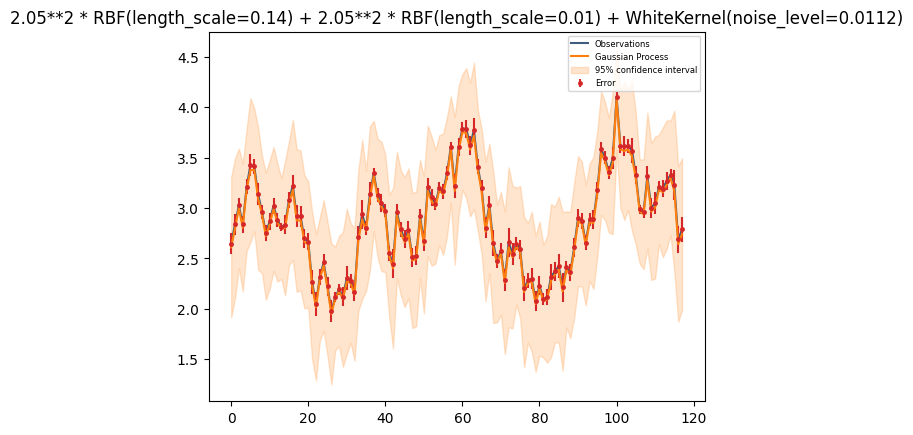

<ipython-input-64-5376ba1a9377>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


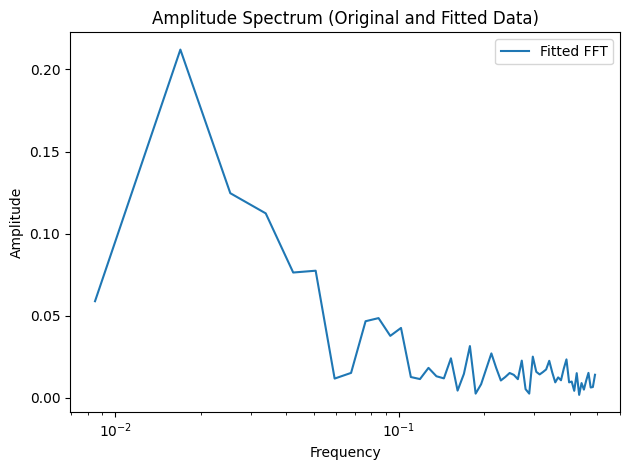

kernals: 1**2 * RBF(length_scale=0.14) + 1**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.01)
Number of training data points: 118
final values of the kernals are: 2.05**2 * RBF(length_scale=0.14) + 2.05**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.0112)
log_likelihood= -293.53234843779126
training datapoint 118
K 5
a= 587.0646968755825
aa= 23.853423122328326
Bayesian Information Criterion (BIC): 610.9181199979108
AIC= 597.0646968755825
(2 * k * (k + 1))= 60
(n - k - 1)= 112
Corrected Akaike Information Criterion (AICc): 5.866649079246272
starting


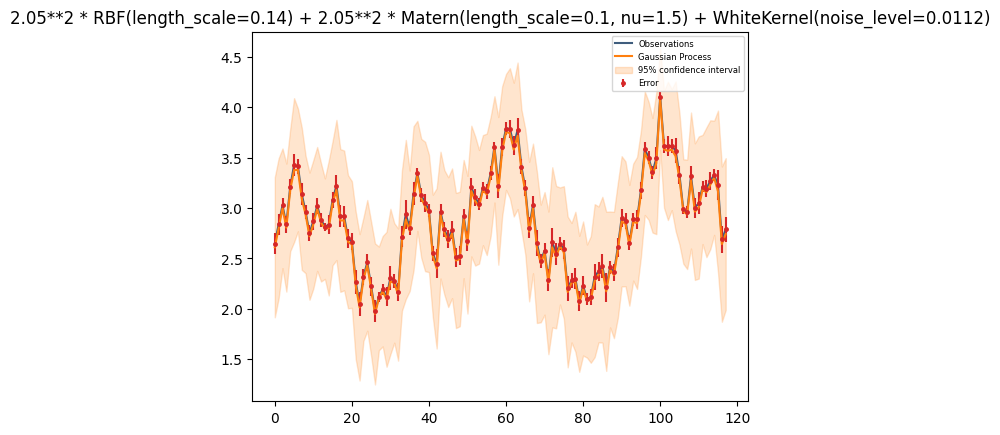

<ipython-input-64-5376ba1a9377>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


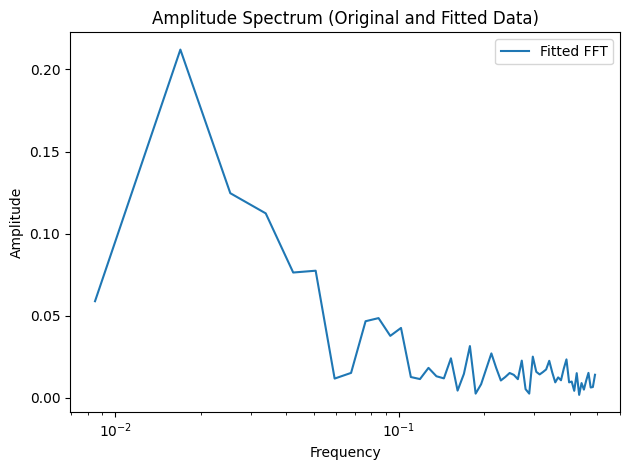

kernals: 1**2 * RBF(length_scale=0.24) + 1**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)
Number of training data points: 118
final values of the kernals are: 3.56**2 * RBF(length_scale=216) + 0.054**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.123)
log_likelihood= -82.4923426209984
training datapoint 118
K 5
a= 164.9846852419968
aa= 23.853423122328326
Bayesian Information Criterion (BIC): 188.83810836432514
AIC= 174.9846852419968
(2 * k * (k + 1))= 60
(n - k - 1)= 112
Corrected Akaike Information Criterion (AICc): 2.098077546803543
starting


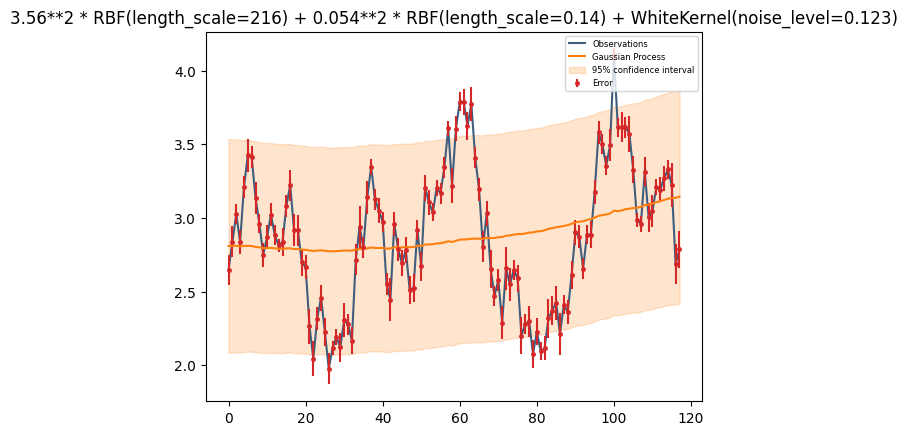

<ipython-input-64-5376ba1a9377>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


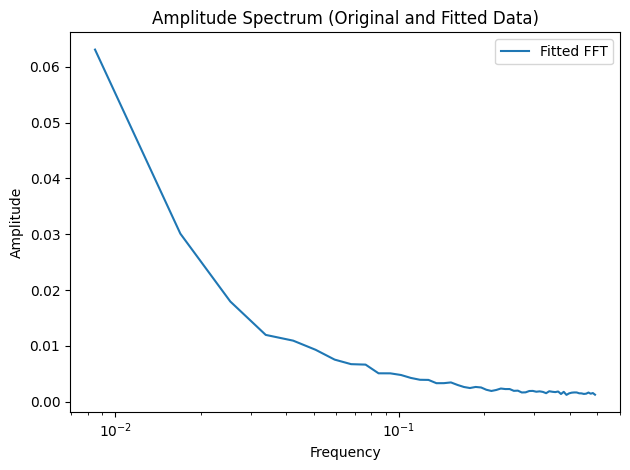

kernals: 1**2 * RBF(length_scale=0.1) + ExpSineSquared(length_scale=0.1, periodicity=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 118
final values of the kernals are: 0.00316**2 * RBF(length_scale=0.1) + ExpSineSquared(length_scale=0.1, periodicity=0.1) + WhiteKernel(noise_level=1e-05)
log_likelihood= -44.215436372757395
training datapoint 118
K 5
a= 88.43087274551479
aa= 23.853423122328326
Bayesian Information Criterion (BIC): 112.28429586784311
AIC= 98.43087274551479
(2 * k * (k + 1))= 60
(n - k - 1)= 112
Corrected Akaike Information Criterion (AICc): 1.4145613637992391


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


starting


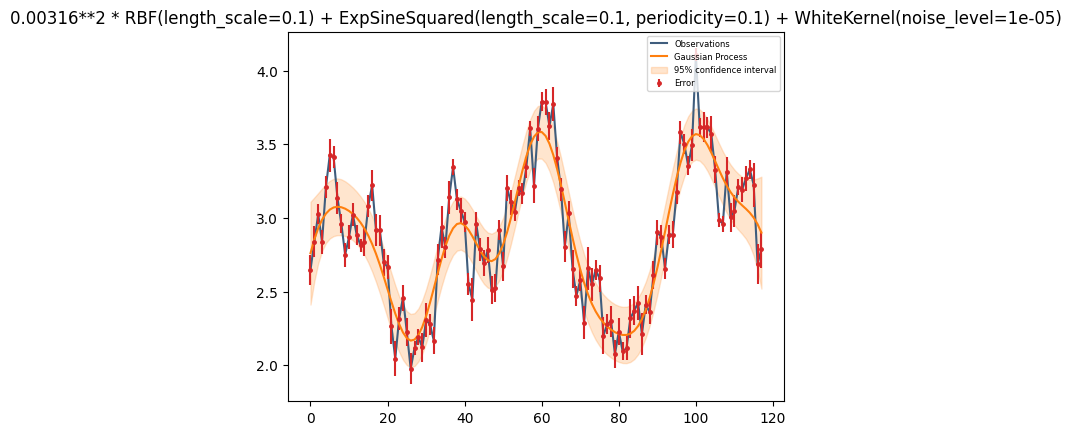

<ipython-input-64-5376ba1a9377>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


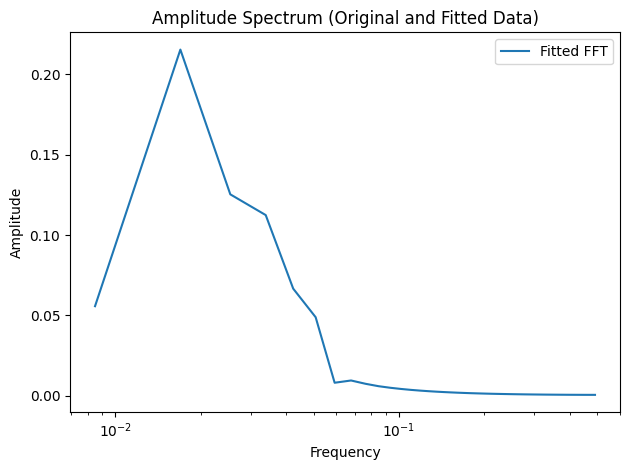

kernals: 1**2 * RBF(length_scale=0.4) + ExpSineSquared(length_scale=0.0001, periodicity=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 118
final values of the kernals are: 1**2 * RBF(length_scale=0.4) + ExpSineSquared(length_scale=0.0001, periodicity=0.1) + WhiteKernel(noise_level=0.01)
log_likelihood= -131.1854332431805
training datapoint 118
K 5
a= 262.370866486361
aa= 23.853423122328326
Bayesian Information Criterion (BIC): 286.22428960868933
AIC= 272.370866486361
(2 * k * (k + 1))= 60
(n - k - 1)= 112
Corrected Akaike Information Criterion (AICc): 2.967597022199652
starting


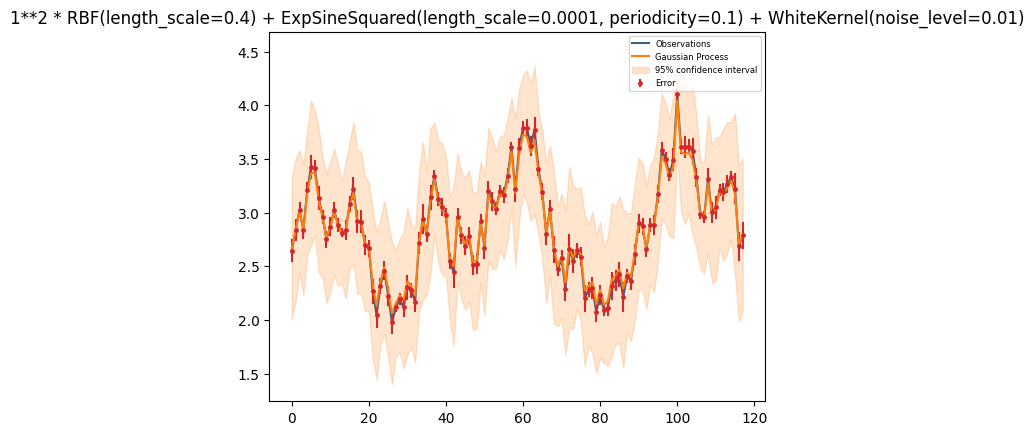

<ipython-input-64-5376ba1a9377>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


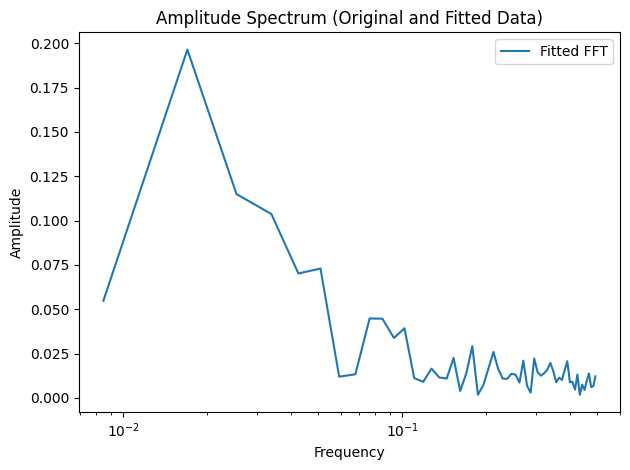

kernals: 1**2 * RBF(length_scale=0.4) + 1**2 * RBF(length_scale=0.2) + 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 118


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 2.21**2 * RBF(length_scale=10.8) + 0.00316**2 * RBF(length_scale=0.2) + 0.00316**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=1e-05)
log_likelihood= -31.98410348012378
training datapoint 118
K 7
a= 63.96820696024756
aa= 33.394792371259655
Bayesian Information Criterion (BIC): 97.36299933150721
AIC= 77.96820696024756
(2 * k * (k + 1))= 112
(n - k - 1)= 110
Corrected Akaike Information Criterion (AICc): 1.726983699638614
starting


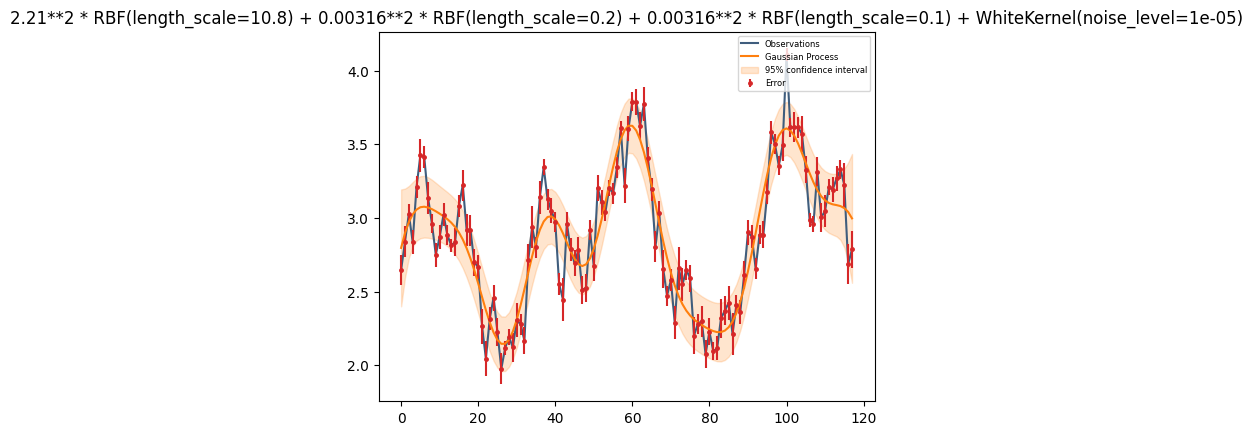

<ipython-input-64-5376ba1a9377>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


None


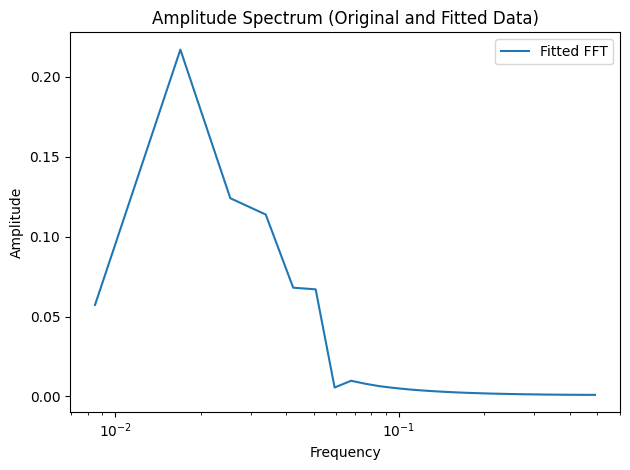

In [64]:
for i, kernel in enumerate(kernels):
  print('kernals:',kernel)
  fig, box1 = plt.subplots()
  t, y, y_error,juldate_min = load_data(data_files[-1])
  juldate_zero, gpr, log_likelihood, final_kernal_value, gpr_kernel_theta, num_training_data, X = Gaussian_process(t, y, y_error, box1,kernel)  # process and plot the first data file on the first axes object
  BIC, AICc, no_parameter = compute_model(num_training_data,gpr_kernel_theta,log_likelihood)
  y_pred, sigma = gpr.predict(X, return_std=True)
  plot_results(t, y, y_error, y_pred, sigma, box1, X)
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': no_parameter,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)
  print(juldate_zero)
  '''
  # Perform FFT analysis for the original data
  positive_freqs, amplitude_original, _ = compute_fft(t, y)
  b3.plot(positive_freqs, amplitude_original, label='Original FFT')
  '''

  # Calculate the FFT of the Gaussian Process fitted curve (y_pred)
  positive_freqs_fitted, amplitude_fitted, _ = compute_fft(X, y_pred.flatten())
  fig, b3 = plt.subplots()
  b3.plot(positive_freqs_fitted, amplitude_fitted, label='Fitted FFT')
  plt.xscale('log')
  b3.set_title('Amplitude Spectrum (Original and Fitted Data)')
  b3.set_xlabel('Frequency')
  b3.set_ylabel('Amplitude')
  b3.legend()

  plt.tight_layout()
  plt.show()


In [65]:
t, y, y_error, juldate_min = load_data(data_files[-1])

cutoff_frequency = 0.1  # Adjust this value based on your data
sampling_frequency = 1.0 / (t[1] - t[0])  # Assuming evenly spaced time points
# Apply the Butterworth filter to the data
filtered_y = butterworth_filter(y, cutoff_frequency, sampling_frequency)

# Perform FFT analysis for both original and filtered data
positive_freqs, amplitude_original, phase_original = compute_fft(t, y)
_, amplitude_filtered, _ = compute_fft(t, filtered_y)

# Plot FFT results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(positive_freqs, amplitude_original, label='Original')
plt.plot(positive_freqs, amplitude_filtered, label='Filtered')
plt.title('Amplitude Spectrum (Before and After Filtering)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
Result_Table_box3

<Figure size 1200x600 with 0 Axes>

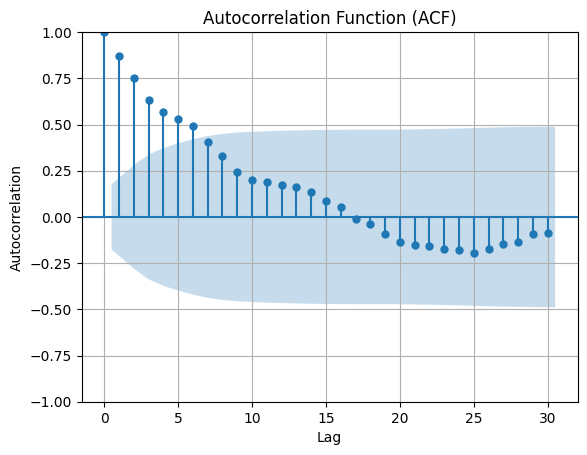

<Figure size 1200x600 with 0 Axes>

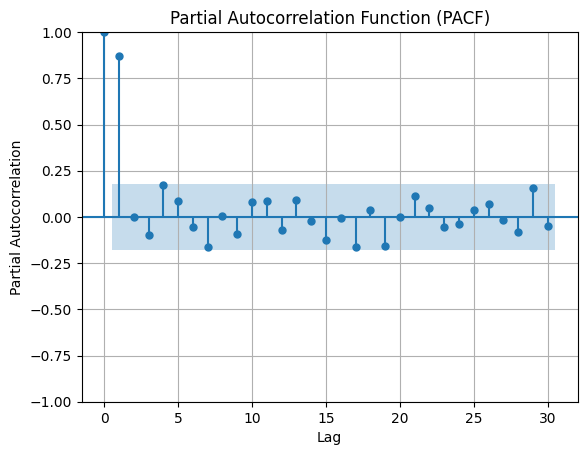

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the data
data = np.genfromtxt(data_files[0])
juldate = data[:, 1]
juldate_zero = juldate_zero if juldate_zero is not None else juldate.min()
tsec = juldate - juldate_zero
t = tsec / 1000.0
y = data[:, 2]
y_error = data[:, 3].T

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(y, lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(y, lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

In [ ]:
def plot_ARMA_predictions(t, y, y_pred, y_error, col1, col2, title):
    plt.plot(t, y, color=col1, linewidth=1.5, label='Observations')
    plt.errorbar(
        t,
        y_pred,  # Use y_pred instead of y here
        yerr=y_error,  # Use y_error instead of y here
        linestyle="None",
        color="tab:red",
        marker=".",
        markersize=5,
        label="Error",
    )
    plt.plot(t, y_pred, color=col2, linewidth=1.5, label='ARMA Model')
    plt.legend(loc='upper right', fontsize="6")
    plt.title(title)

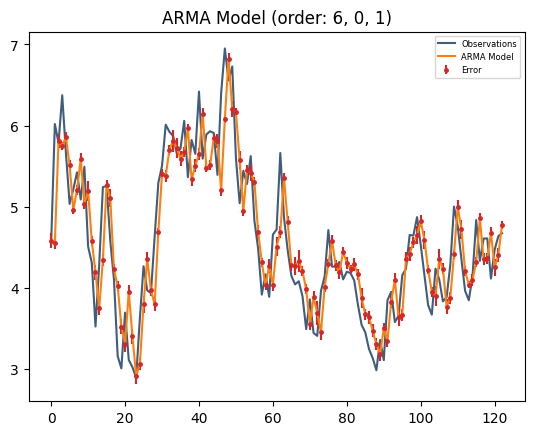

training datapoint 123
K 2
a= 149.18509401344247
aa= 9.624368710744834
Bayesian Information Criterion (BIC): 158.8094627241873
AIC= 153.18509401344247
(2 * k * (k + 1))= 12
(n - k - 1)= 120
Corrected Akaike Information Criterion (AICc): 1.3765424501120205
Bayesian Information Criterion (BIC): 158.8094627241873
Corrected Akaike Information Criterion (AICc): 1.3765424501120205
Number of parameters: 2


In [ ]:
p=6
q=1
t, y, y_error, juldate_zero = load_data(data_files[0])
X = t.reshape(-1, 1)
y = y.reshape(-1, 1)
num_training_data = t.shape[0]

model = ARIMA(y, order=(p, 0, q))
model_fit = model.fit()
y_pred = model_fit.predict(start=0, end=num_training_data - 1)
title = f"ARMA Model (order: {p}, 0, {q})"
plot_ARMA_predictions(t, y, y_pred, y_error, col1, col2, title)
plt.show()

# Compute and print the model statistics
parameters = [p, q]
Likelihood = model_fit.llf
BIC, AICc, no_parameter = compute_model(num_training_data, parameters, Likelihood)

print("Bayesian Information Criterion (BIC):", BIC)
print("Corrected Akaike Information Criterion (AICc):", AICc)
print("Number of parameters:", no_parameter)

<Figure size 1200x600 with 0 Axes>

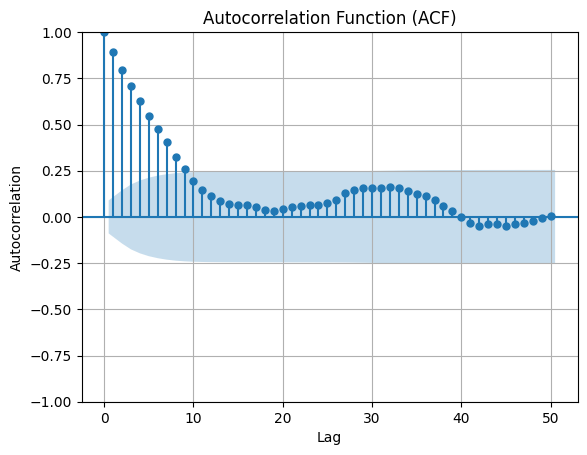

<Figure size 1200x600 with 0 Axes>

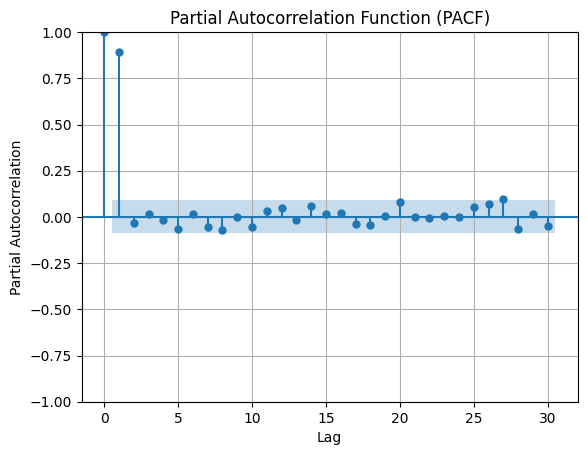

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the data
data = np.genfromtxt('fvar_soft_dt1000_combined.dat')
juldate = data[:, 1]
juldate_zero = juldate_zero if juldate_zero is not None else juldate.min()
tsec = juldate - juldate_zero
t = tsec / 1000.0
y = data[:, 2]
y_error = data[:, 3].T

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(y, lags=50, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(y, lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

In [ ]:
from scipy import interpolate

def interpolate_missing_values(data_combined):
    x = data_combined[:, 1]
    y = data_combined[:, 2]
    nan_indices = np.isnan(y)
    y[nan_indices] = interpolate.interp1d(x[~nan_indices], y[~nan_indices], kind='linear')(x[nan_indices])
    return data_combined

In [ ]:
def bfill_missing_values(data_combined):
    nan_mask = np.isnan(data_combined[:, 1])  # Mask for missing values in the y column
    data_combined[nan_mask, 1] = np.nan  # Set missing values to NaN to avoid incorrect backfilling
    data_combined[:, 1] = np.where(nan_mask, np.nan, data_combined[:, 1])  # Replace NaNs in the y column with original values
    return data_combined

In [ ]:
df=np.genfromtxt('fvar_soft_dt1000_combined_with_values.dat')
df

array([[5.000000e+00, 5.354649e+08, 3.064027e+00, 1.352398e-01,
        3.972612e-03],
       [1.005000e+03, 5.354659e+08, 2.481655e+00, 1.027394e-01,
        3.345357e-03],
       [2.005000e+03, 5.354669e+08, 2.747491e+00, 9.423223e-02,
        2.509018e-03],
       ...,
       [1.230050e+05, 5.361006e+08, 2.816659e+00, 1.024327e-01,
        7.341176e-03],
       [1.240050e+05, 5.361016e+08, 2.894988e+00, 1.004270e-01,
        1.101176e-02],
       [1.250050e+05, 5.361026e+08, 2.842698e+00, 8.763326e-02,
        5.301961e-03]])

In [ ]:
data_combined_interpolated = interpolate_missing_values(df)
np.savetxt('fvar_soft_dt1000_combined_with_interpolation.dat', data_combined_interpolated)


In [ ]:
t, y, y_error, juldate_zero = load_data('fvar_soft_dt1000_combined_with_bfill.dat')
df1= pd.DataFrame()
df1['T']=t
df1['Y']=y
df1['Y-error']=y_error
df1

FileNotFoundError: ignored

In [ ]:
p=9
q=1
t, y, y_error, juldate_zero = load_data('fvar_soft_dt1000_combined_with_interpolation.dat')
X = t.reshape(-1, 1)
y = y.reshape(-1, 1)
num_training_data = t.shape[0]

model = ARIMA(y, order=(p, 0, q))
model_fit = model.fit()
t1, y1, y_error1, juldate_zero1 = load_data('fvar_soft_dt1000_combined_with_values.dat')
X1 = t.reshape(-1, 1)
y1 = y.reshape(-1, 1)
num_training_data1 = t1.shape[0]
print(num_training_data1)
y_pred = model_fit.predict(start=0, end=num_training_data - 1)
#y_pred = model_fit.predict(start=0, end=num_training_data1 - 1)
title = f"ARMA Model (order: {p}, 0, {q})"
plot_ARMA_predictions(t, y, y_pred, y_error, col1, col2, title)
'''
t1, y1, y_error1, juldate_zero1 = load_data('fvar_soft_dt1000_combined_with_values.dat')
X1 = t.reshape(-1, 1)
y1 = y.reshape(-1, 1)
num_training_data1 = t.shape[0]
y_pred1 = model_fit.predict(start=0, end=num_training_data1 - 1)
plot_ARMA_predictions(t1, y1, y_pred1, y_error1, col1, col2, title)
'''


In [ ]:
# Convert combined data to DataFrame
column_names = ['time', 't', 'y', 'y_error','bkg']  # Adjust with your column names
df_combined = pd.DataFrame(data_combined, columns=column_names)
# Bfill imputation
#df_imputed = df_combined.fillna(method='bfill')
#df_imputed = df_combined.interpolate(method='linear')
# KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed
df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_combined), columns=df_combined.columns)
# Save the imputed data to a .dat file without column indices
imputed_dat_filename = 'fvar_soft_dt1000_combined_imputed.dat'
df_imputed.to_csv(imputed_dat_filename, sep=' ', header=False, index=False)

In [ ]:
df_imputed

In [ ]:
p=9
q=1
t, y, y_error, juldate_zero = load_data('fvar_soft_dt1000_combined_imputed.dat')
X = t.reshape(-1, 1)
y = y.reshape(-1, 1)
num_training_data = t.shape[0]

model = ARIMA(y, order=(p, 0, q))
model_fit = model.fit()
y_pred = model_fit.predict(start=0, end=num_training_data - 1)
title = f"ARMA Model (order: {p}, 0, {q})"
plot_ARMA_predictions(t, y, y_pred, y_error, col1, col2, title)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the data
data = np.genfromtxt(data_files[-1])
juldate = data[:, 1]
juldate_zero = juldate_zero if juldate_zero is not None else juldate.min()
tsec = juldate - juldate_zero
t = tsec / 1000.0
y = data[:, 2]
y_error = data[:, 3].T

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(y, lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(y, lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

In [ ]:
p=5
q=1
t, y, y_error, juldate_zero = load_data(data_files[0])
X = t.reshape(-1, 1)
y = y.reshape(-1, 1)
num_training_data = t.shape[0]

model = ARIMA(y, order=(p, 0, q))
model_fit = model.fit()
y_pred = model_fit.predict(start=0, end=num_training_data - 1)
title = f"ARMA Model (order: {p}, 0, {q})"
plot_ARMA_predictions(t, y, y_pred, y_error, col1, col2, title)
plt.show()

# Compute and print the model statistics
parameters = [p, q]
Likelihood = model_fit.llf
BIC, AICc, no_parameter = compute_model(num_training_data, parameters, Likelihood)

print("Bayesian Information Criterion (BIC):", BIC)
print("Corrected Akaike Information Criterion (AICc):", AICc)
print("Number of parameters:", no_parameter)